In [2]:
# Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, shapiro

In [4]:
# Loading the dataset
df = pd.read_csv("Dados/Brasileirao.csv", delimiter=",")
df.head()

,ano_campeonato,data,gols_mandante,gols_visitante,publico,publico_max,time_mandante,time_visitante
0,2012,2012-05-27,1.0,0.0,18277.0,NaN,Grêmio,Palmeiras
1,2012,2012-07-01,0.0,1.0,34550.0,NaN,Grêmio,Atlético-MG
2,2012,2012-07-18,3.0,1.0,15179.0,NaN,Grêmio,Sport Recife
3,2012,2012-07-25,1.0,0.0,27405.0,NaN,Grêmio,Fluminense
4,2012,2012-08-15,1.0,2.0,15798.0,NaN,Grêmio,Portuguesa


In [5]:
# Renaming columns in the original DataFrame df
df.rename(columns={
    'ano_campeonato': 'season_year',
    'data': 'date',
    'gols_mandante': 'home_goals',
    'gols_visitante': 'away_goals',
    'publico': 'attendance',
    'publico_max': 'max_attendance',
    'time_mandante': 'home_team',
    'time_visitante': 'away_team'
}, inplace=True)

# ===== DATA CLEANING =====

# Filtering only matches involving Corinthians
df_cor = df[(df['home_team'] == 'Corinthians') | (df['away_team'] == 'Corinthians')].copy()

# Removing the year 2020 due to the pandemic
df_cor['date'] = pd.to_datetime(df_cor['date'], errors='coerce')
df_cor = df_cor[df_cor['date'].dt.year != 2020]

# Creating helper columns
df_cor['home'] = df_cor['home_team'] == 'Corinthians'
df_cor['corinthians_goals'] = df_cor.apply(
    lambda row: row['home_goals'] if row['home'] else row['away_goals'], axis=1)
df_cor['opponent_goals'] = df_cor.apply(
    lambda row: row['away_goals'] if row['home'] else row['home_goals'], axis=1)
df_cor['goal_difference'] = df_cor['corinthians_goals'] - df_cor['opponent_goals']
df_cor['location'] = df_cor['home'].map({True: 'Home', False: 'Away'})

df_cor.head()


,season_year,date,home_goals,away_goals,attendance,max_attendance,home_team,away_team,home,corinthians_goals,opponent_goals,goal_difference,location
31,2012,2012-07-29,0.0,0.0,24648.0,NaN,EC Bahia,Corinthians,False,0.0,0.0,0.0,Away
42,2012,2012-07-18,0.0,3.0,14897.0,NaN,Flamengo,Corinthians,False,3.0,0.0,3.0,Away
68,2012,2012-09-16,0.0,2.0,24692.0,43600.0,Palmeiras,Corinthians,False,2.0,0.0,2.0,Away
84,2012,2012-08-29,1.0,1.0,9062.0,NaN,Fluminense,Corinthians,False,1.0,1.0,0.0,Away
111,2012,2012-05-20,0.0,1.0,14791.0,37730.0,Corinthians,Fluminense,True,0.0,1.0,-1.0,Home


In [6]:
# Splitting by location
home = df_cor[df_cor['home']]
away = df_cor[~df_cor['home']]

In [7]:

# ===== FREQUENCY TABLES: CORINTHIANS GOALS =====

# Absolute frequency of goals
freq_goals_abs = pd.DataFrame({
    'Home': home['corinthians_goals'].value_counts().sort_index(),
    'Away': away['corinthians_goals'].value_counts().sort_index()
}).fillna(0).astype(int)

# Relative frequency of goals (%)
freq_goals_rel = pd.DataFrame({
    'Home (%)': (home['corinthians_goals'].value_counts(normalize=True) * 100).sort_index(),
    'Away (%)': (away['corinthians_goals'].value_counts(normalize=True) * 100).sort_index()
}).fillna(0).round(2)

freq_goals = pd.concat([freq_goals_abs, freq_goals_rel], axis=1)

print("===== Frequency Table: Corinthians Goals =====")
print(freq_goals)

# ===== FREQUENCY TABLES: CORINTHIANS GOAL DIFFERENCE =====

# Absolute frequency of goal difference
freq_diff_abs = pd.DataFrame({
    'Home': home['goal_difference'].value_counts().sort_index(),
    'Away': away['goal_difference'].value_counts().sort_index()
}).fillna(0).astype(int)

# Relative frequency of goal difference (%)
freq_diff_rel = pd.DataFrame({
    'Home (%)': (home['goal_difference'].value_counts(normalize=True) * 100).sort_index(),
    'Away (%)': (away['goal_difference'].value_counts(normalize=True) * 100).sort_index()
}).fillna(0).round(2)

freq_diff = pd.concat([freq_diff_abs, freq_diff_rel], axis=1)

print("\n===== Frequency Table: Corinthians Goal Difference =====")
print(freq_diff)

===== Frequency Table: Corinthians Goals =====
                   Home  Away  Home (%)  Away (%)
corinthians_goals                                
0.0                  75   135     19.69     35.53
1.0                 143   139     37.53     36.58
2.0                  91    72     23.88     18.95
3.0                  51    23     13.39      6.05
4.0                  11     9      2.89      2.37
5.0                   7     2      1.84      0.53
6.0                   2     0      0.52      0.00
7.0                   1     0      0.26      0.00

===== Frequency Table: Corinthians Goal Difference =====
                 Home  Away  Home (%)  Away (%)
goal_difference                                
-5.0                1     1      0.26      0.26
-4.0                3     5      0.79      1.32
-3.0                8    13      2.10      3.42
-2.0               16    34      4.20      8.95
-1.0               38   100      9.97     26.32
 0.0              109   118     28.61     31.05
 1.0       

In [8]:
# Descriptive statistics
goals_stats = pd.concat([
    home['corinthians_goals'].describe().round(2).rename("Home"),
    away['corinthians_goals'].describe().round(2).rename("Away")
], axis=1)

diff_stats = pd.concat([
    home['goal_difference'].describe().round(2).rename("Home"),
    away['goal_difference'].describe().round(2).rename("Away")
], axis=1)

print("===== Descriptive Statistics: Goals =====")
print(goals_stats)

print("\n===== Descriptive Statistics: Goal Difference =====")
print(diff_stats)

===== Descriptive Statistics: Goals =====
         Home    Away
count  381.00  380.00
mean     1.51    1.05
std      1.22    1.04
min      0.00    0.00
25%      1.00    0.00
50%      1.00    1.00
75%      2.00    2.00
max      7.00    5.00

===== Descriptive Statistics: Goal Difference =====
         Home    Away
count  381.00  380.00
mean     0.61   -0.19
std      1.52    1.40
min     -5.00   -5.00
25%      0.00   -1.00
50%      1.00    0.00
75%      1.00    1.00
max      6.00    4.00


In [9]:
# Normality tests
print("\n===== Normality Test (Shapiro-Wilk) =====")
print("Goals - Home:", shapiro(home['corinthians_goals']))
print("Goals - Away:", shapiro(away['corinthians_goals']))
print("Difference - Home:", shapiro(home['goal_difference']))
print("Difference - Away:", shapiro(away['goal_difference']))


===== Normality Test (Shapiro-Wilk) =====
Goals - Home: ShapiroResult(statistic=0.8766739854096572, pvalue=6.979440494937062e-17)
Goals - Away: ShapiroResult(statistic=0.8365480146147037, pvalue=2.185276146873852e-19)
Difference - Home: ShapiroResult(statistic=0.9430964874245047, pvalue=6.430712901589431e-11)
Difference - Away: ShapiroResult(statistic=0.9511831942522873, pvalue=6.866596395370754e-10)


In [10]:
# Mann-Whitney tests
stat_goals, p_goals = mannwhitneyu(home['corinthians_goals'], away['corinthians_goals'], alternative='two-sided')
stat_diff, p_diff = mannwhitneyu(home['goal_difference'], away['goal_difference'], alternative='two-sided')

print(f"\n===== Mann-Whitney Tests =====")
print(f"Corinthians Goals: U={stat_goals}, p={p_goals:.4e}")
print(f"Goal Difference: U={stat_diff}, p={p_diff:.4e}")


===== Mann-Whitney Tests =====
Corinthians Goals: U=88650.0, p=2.1573e-08
Goal Difference: U=95690.5, p=3.2165e-15


C:\Users\mary-\AppData\Local\Temp\ipykernel_9452\1686407658.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(home['corinthians_goals'], label='Home', shade=True)
C:\Users\mary-\AppData\Local\Temp\ipykernel_9452\1686407658.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(away['corinthians_goals'], label='Away', shade=True)
C:\Users\mary-\AppData\Local\Temp\ipykernel_9452\1686407658.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(home['goal_difference'], label='Home', shade=True)
C:\Users\mary-\AppData\Local\Temp\ipykernel_9452\1686407658.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; sett

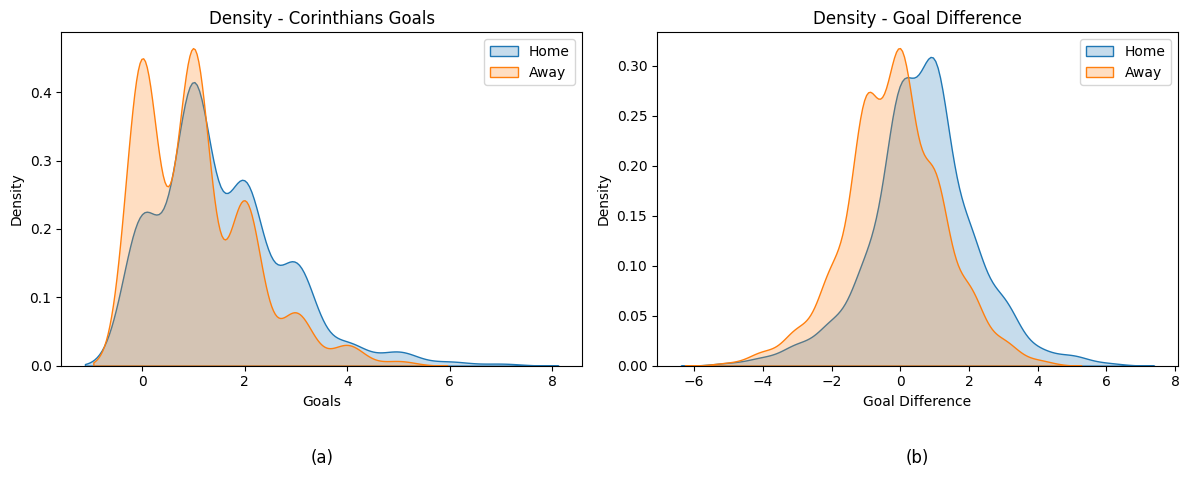

In [11]:
# KDE plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(home['corinthians_goals'], label='Home', shade=True)
sns.kdeplot(away['corinthians_goals'], label='Away', shade=True)
plt.title('Density - Corinthians Goals')
plt.xlabel('Goals')
plt.ylabel('Density')
plt.legend()
plt.text(0.5, -0.25, '(a)', transform=plt.gca().transAxes, ha='center', va='top', fontsize=12)

plt.subplot(1, 2, 2)
sns.kdeplot(home['goal_difference'], label='Home', shade=True)
sns.kdeplot(away['goal_difference'], label='Away', shade=True)
plt.title('Density - Goal Difference')
plt.xlabel('Goal Difference')
plt.ylabel('Density')
plt.legend()
plt.text(0.5, -0.25, '(b)', transform=plt.gca().transAxes, ha='center', va='top', fontsize=12)

plt.tight_layout()
plt.show()

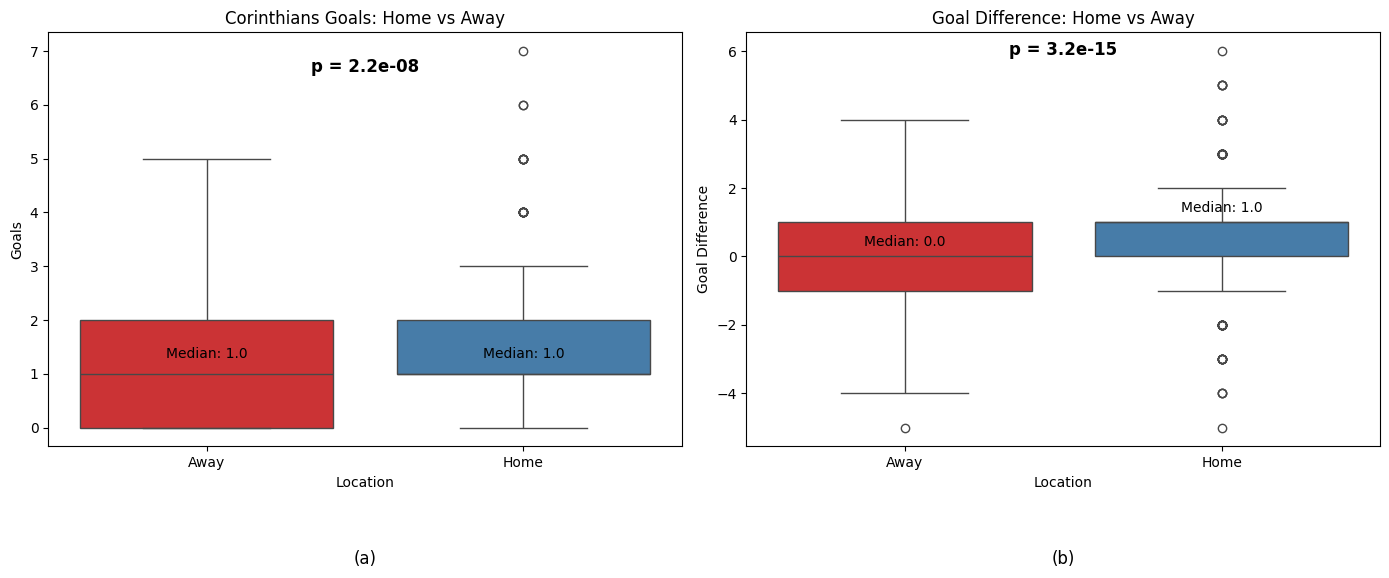

In [12]:
# Boxplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=df_cor, x='location', y='corinthians_goals', hue='location', ax=axs[0], palette='Set1', legend=False)
axs[0].set_title('Corinthians Goals: Home vs Away')
axs[0].set_ylabel('Goals')
axs[0].set_xlabel('Location')
axs[0].text(0.5, -0.25, '(a)', transform=axs[0].transAxes, ha='center', va='top', fontsize=12)

sns.boxplot(data=df_cor, x='location', y='goal_difference', hue='location', ax=axs[1], palette='Set1', legend=False)
axs[1].set_title('Goal Difference: Home vs Away')
axs[1].set_ylabel('Goal Difference')
axs[1].set_xlabel('Location')
axs[1].text(0.5, -0.25, '(b)', transform=axs[1].transAxes, ha='center', va='top', fontsize=12)

for ax, col, p_val in zip(axs, ['corinthians_goals', 'goal_difference'], [p_goals, p_diff]):
    medians = df_cor.groupby('location')[col].median()
    for i, loc in enumerate(['Away', 'Home']):
        ax.text(i, medians[loc] + 0.3, f'Median: {medians[loc]:.1f}', ha='center', fontsize=10, color='black')
    ax.text(0.5, ax.get_ylim()[1]*0.9, f'p = {p_val:.1e}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


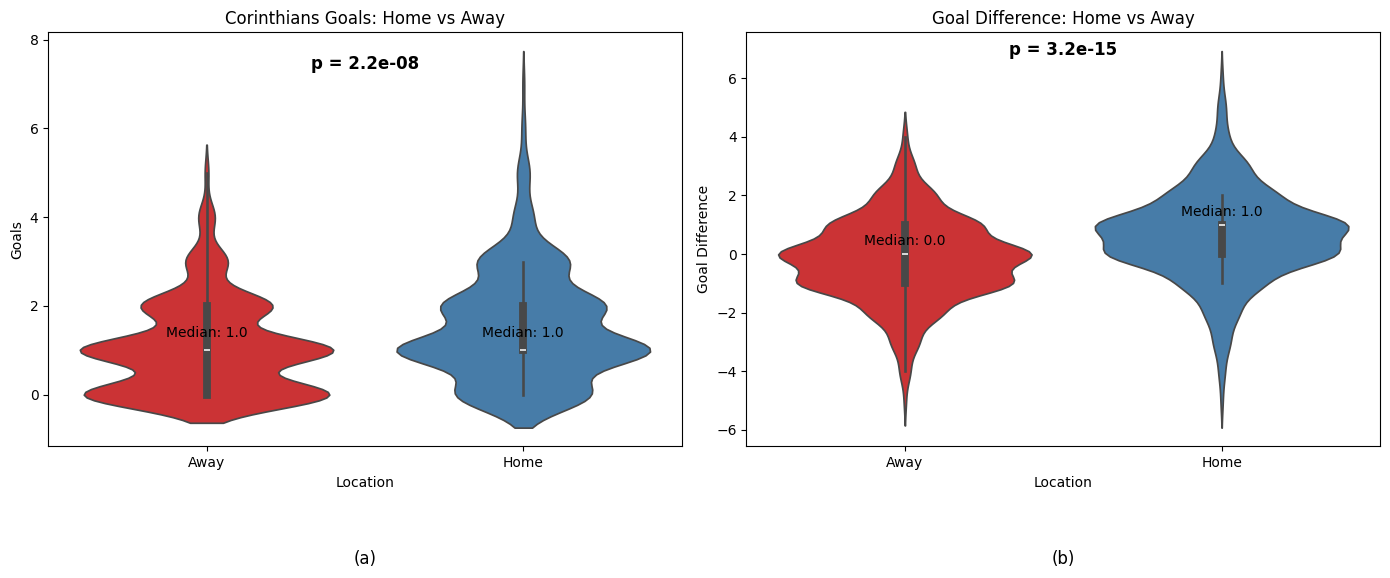

In [13]:
# Violin plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(data=df_cor, x='location', y='corinthians_goals', hue='location', ax=axs[0], palette='Set1', legend=False, inner='box')
axs[0].set_title('Corinthians Goals: Home vs Away')
axs[0].set_ylabel('Goals')
axs[0].set_xlabel('Location')
axs[0].text(0.5, -0.25, '(a)', transform=axs[0].transAxes, ha='center', va='top', fontsize=12)

sns.violinplot(data=df_cor, x='location', y='goal_difference', hue='location', ax=axs[1], palette='Set1', legend=False, inner='box')
axs[1].set_title('Goal Difference: Home vs Away')
axs[1].set_ylabel('Goal Difference')
axs[1].set_xlabel('Location')
axs[1].text(0.5, -0.25, '(b)', transform=axs[1].transAxes, ha='center', va='top', fontsize=12)

for ax, col, p_val in zip(axs, ['corinthians_goals', 'goal_difference'], [p_goals, p_diff]):
    medians = df_cor.groupby('location')[col].median()
    for i, loc in enumerate(['Away', 'Home']):
        ax.text(i, medians[loc] + 0.3, f'Median: {medians[loc]:.1f}', ha='center', fontsize=10, color='black')
    ax.text(0.5, ax.get_ylim()[1]*0.9, f'p = {p_val:.1e}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
